## On the Effects of Climate Change on Network Complexity and Public Transit Failure in Dubai RTA

As climate change's threat begins to loom closer, it is in the best interest of large metropolitan areas to begin preparing their infrastructure accordingly. Historically, people have modeled weather to identify vulnerable, climate-prone, areas within public transit systems. While this is definitely a needed POV, many of these analyses tend to ignore network complexity of a transit system. Though climate effects many systems directly through weather-related damages, these same effects can lead to indirect pathways of failure (Markolf, 2019). 

One of the indirect effects that can exacerbate damages related to climate change is network complexity. A highly complex network is subjected to more "wear and tear", thus needing frequent repairs, and maintenance. However, these sorts of networks are typically remnants of old infrastructure and are thus difficult to update to models that accomodate towards climate-resiliency (Markolf, 2019). Additionally, a highly connected station that experiences failure could spell disaster for the network at large, as many lines may depend on this station for normal function (Markolf, 2019). 

Making a transit system dependent on this sort of network design is unsustainable and efforts must be taken to update routes and infrastructure to better prepare for future events. In this notebook, I will highlight Dubai RTA's vulnerability to these effects. Additionally, I provide a Random Forest Regression model that can serve as a tool for readers to begin preparing plans to take action. The model works to exemplify the increasingly varying temperatures found in Dubai as climate-changes effects begin to intesnify.

#### Credits: 
Thank you to the National Data Science Society for providing access to Dubai's historical meterological data, and to the people behind Dubai Pulse, who have provided open access to Dubai's RTA data.


I'm always looking to improve, so feedback is always welcome!
<br> 
##### David Lopez
University of California, San Diego
<br> david.eric.lopez@gmail.com

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

### Cleaning Weather Data

In [2]:
# Reading in the weather data
weath_df = pd.read_json('weather_data.json')

In [3]:
#presenting weather data head
weath_df.head()

,city_name,lat,lon,main,wind,clouds,weather,dt,dt_iso,timezone,rain
0,Dubai,25.07501,55.188761,"{'temp': 14.99, 'temp_min': 13, 'temp_max': 18...","{'speed': 3.1, 'deg': 150}",{'all': 1},"[{'id': 800, 'main': 'Clear', 'description': '...",1514764800,2018-01-01 00:00:00 +0000 UTC,14400,NaN
1,Dubai,25.07501,55.188761,"{'temp': 14.63, 'temp_min': 13, 'temp_max': 17...","{'speed': 2.6, 'deg': 150}",{'all': 1},"[{'id': 800, 'main': 'Clear', 'description': '...",1514768400,2018-01-01 01:00:00 +0000 UTC,14400,NaN
2,Dubai,25.07501,55.188761,"{'temp': 14.03, 'temp_min': 12, 'temp_max': 17...","{'speed': 1.5, 'deg': 150}",{'all': 1},"[{'id': 800, 'main': 'Clear', 'description': '...",1514772000,2018-01-01 02:00:00 +0000 UTC,14400,NaN
3,Dubai,25.07501,55.188761,"{'temp': 13.78, 'temp_min': 12, 'temp_max': 17...","{'speed': 2.1, 'deg': 180}",{'all': 1},"[{'id': 701, 'main': 'Mist', 'description': 'm...",1514775600,2018-01-01 03:00:00 +0000 UTC,14400,NaN
4,Dubai,25.07501,55.188761,"{'temp': 14.28, 'temp_min': 12, 'temp_max': 18...","{'speed': 2.6, 'deg': 160}",{'all': 1},"[{'id': 701, 'main': 'Mist', 'description': 'm...",1514779200,2018-01-01 04:00:00 +0000 UTC,14400,NaN


In [4]:
# Ensuring these values are safe to drop from the datafram
# If values don't vary, then it will be assumed that all data points address the same region
print('unique timezones', weath_df['timezone'].unique())
print('unique lat''s', weath_df['lat'].unique())
print('unique lon''s', weath_df['lon'].unique())

unique timezones [14400]
unique lats [25.07501]
unique lons [55.188761]


In [5]:
# Expanding the dictionaries within each column
# Converting the dictionary keys to columns, and their values to index entries
weath_df = pd.concat([weath_df.drop(['main'], axis=1), weath_df['main'].apply(pd.Series)], axis=1)
weath_df = pd.concat([weath_df.drop(['wind'], axis=1), weath_df['wind'].apply(pd.Series)], axis=1)
weath_df = pd.concat([weath_df.drop(['clouds'], axis=1), weath_df['clouds'].apply(pd.Series)], axis=1)
weath_df = pd.concat([weath_df.drop(['rain'], axis=1), weath_df['rain'].apply(pd.Series)], axis=1)

# Weather column is nested within a list
# Extracting items from the list and extracting data from the nested dictionaries
weath_df.applymap(lambda x: x[0] if isinstance(x, list) else x)
weath_df = pd.concat([weath_df.drop(['weather'], axis=1), weath_df['weather'].apply(pd.Series)], axis=1)
weath_df = pd.concat([weath_df.drop([0], axis=1), weath_df[0].apply(pd.Series)], axis=1)
weath_df = pd.concat([weath_df.drop([1], axis=1), weath_df[1].apply(pd.Series)], axis=1)

#renaming columns
weath_df = weath_df.rename(columns = {'dt_iso': 'date', 'speed': 'wind_speed', 
                                      'deg':'wind_deg', 'all':'pct_cloudy','1h':'rv_1h', '3h': 'rv_3h'})

In [6]:
#presenting the head of the weather column
weath_df.head()

,city_name,lat,lon,dt,date,timezone,temp,temp_min,temp_max,feels_like,...,pct_cloudy,rv_1h,rv_3h,0,0,0,description,icon,id,main
0,Dubai,25.07501,55.188761,1514764800,2018-01-01 00:00:00 +0000 UTC,14400,14.99,13.0,18.0,13.70,...,1,NaN,NaN,NaN,"{'id': 800, 'main': 'Clear', 'description': 's...",NaN,NaN,NaN,NaN,NaN
1,Dubai,25.07501,55.188761,1514768400,2018-01-01 01:00:00 +0000 UTC,14400,14.63,13.0,17.0,13.91,...,1,NaN,NaN,NaN,"{'id': 800, 'main': 'Clear', 'description': 's...",NaN,NaN,NaN,NaN,NaN
2,Dubai,25.07501,55.188761,1514772000,2018-01-01 02:00:00 +0000 UTC,14400,14.03,12.0,17.0,13.89,...,1,NaN,NaN,NaN,"{'id': 800, 'main': 'Clear', 'description': 's...",NaN,NaN,NaN,NaN,NaN
3,Dubai,25.07501,55.188761,1514775600,2018-01-01 03:00:00 +0000 UTC,14400,13.78,12.0,17.0,13.14,...,1,NaN,NaN,NaN,"{'id': 701, 'main': 'Mist', 'description': 'mi...",NaN,NaN,NaN,NaN,NaN
4,Dubai,25.07501,55.188761,1514779200,2018-01-01 04:00:00 +0000 UTC,14400,14.28,12.0,18.0,13.45,...,1,NaN,NaN,NaN,"{'id': 701, 'main': 'Mist', 'description': 'mi...",NaN,NaN,NaN,NaN,NaN


In [7]:
# Function to seperate date and time drom the dt_iso column
# Initializing a list that will store the time values extracted through the function

times = []
def time_cleaner(string):

    #string -> string object found within the dt_iso column
    
  # removing whitespace and dropping unnecessary info
  string = string.strip()
  string = string.replace('+0000 UTC','')
  
  # Assigning a date and time to each entry based on its string contents
  if '00:00:00' in string:
    time = 0
    string = string.replace('00:00:00','')
  
  elif '01:00:00' in string:
    time = 1
    string = string.replace('01:00:00','')

  elif '02:00:00' in string:
    time = 2
    string = string.replace('02:00:00','')

  elif '03:00:00' in string:
    time = 3
    string = string.replace('03:00:00','')

  elif '04:00:00' in string:
    time = 4
    string = string.replace('04:00:00','')

  elif '05:00:00' in string:
    time = 5
    string = string.replace('05:00:00','')

  elif '06:00:00' in string:
    time = 6
    string = string.replace('06:00:00','')

  elif '07:00:00' in string:
    time = 7
    string = string.replace('07:00:00','')

  elif '08:00:00' in string:
    time = 8
    string = string.replace('08:00:00','')

  elif '09:00:00' in string:
    time = 9
    string = string.replace('09:00:00','')

  elif '10:00:00' in string:
    time = 10
    string = string.replace('10:00:00','')

  elif '11:00:00' in string:
    time = 11
    string = string.replace('11:00:00','')

  elif '12:00:00' in string:
    time = 12
    string = string.replace('12:00:00','')

  elif '13:00:00' in string:
    time = 13
    string = string.replace('13:00:00','')

  elif '14:00:00' in string:
    time = 14
    string = string.replace('14:00:00','')

  elif '15:00:00' in string:
    time = 15
    string = string.replace('15:00:00','')

  elif '16:00:00' in string:
    time = 16
    string = string.replace('16:00:00','')

  elif '17:00:00' in string:
    time = 17
    string = string.replace('17:00:00','')

  elif '18:00:00' in string:
    time = 18
    string = string.replace('18:00:00','')

  elif '19:00:00' in string:
    time = 19
    string = string.replace('19:00:00','')

  elif '20:00:00' in string:
    time = 20
    string = string.replace('20:00:00','')

  elif '21:00:00' in string:
    time = 21
    string = string.replace('21:00:00','')

  elif '22:00:00' in string:
    time = 22
    string = string.replace('22:00:00','')

  elif '23:00:00' in string:
    time = 23
    string = string.replace('23:00:00','')

  else:
    time = np.nan
    string = np.nan

  # clearing whitespace once more
  string = string.strip()

  # appending time values to the pre-created list
  times.append(time)
  
  return string

# applying the function to the dt_iso column
weath_df['date'] = weath_df['date'].apply(time_cleaner)

# creating the time column
weath_df['time'] = times


In [8]:
# finalizing the columns to be included within the data frame
weath_df = weath_df[['date','time','main', 'temp','temp_min', 'temp_max', 'feels_like','pressure', 'humidity', 
                     'wind_speed', 'wind_deg', 'pct_cloudy', 'rv_1h', 'rv_3h']]

#### Analysis on cleaned weather data

In [9]:
#Cleaned weather data
weath_df.head()

,date,time,main,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,pct_cloudy,rv_1h,rv_3h
0,2018-01-01,0,NaN,14.99,13.0,18.0,13.70,1015.0,87.0,3.1,150.0,1,NaN,NaN
1,2018-01-01,1,NaN,14.63,13.0,17.0,13.91,1015.0,93.0,2.6,150.0,1,NaN,NaN
2,2018-01-01,2,NaN,14.03,12.0,17.0,13.89,1016.0,93.0,1.5,150.0,1,NaN,NaN
3,2018-01-01,3,NaN,13.78,12.0,17.0,13.14,1016.0,93.0,2.1,180.0,1,NaN,NaN
4,2018-01-01,4,NaN,14.28,12.0,18.0,13.45,1017.0,93.0,2.6,160.0,1,NaN,NaN


In [10]:
# Checking the shape of the weather data
weath_df.shape

(19344, 14)

In [11]:
# Description of weather data

weath_df.describe()

,time,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,pct_cloudy,rv_1h,rv_3h
count,19344.000000,19344.000000,19344.000000,19344.000000,19344.000000,19344.000000,19344.000000,19344.000000,19344.000000,19344.000000,28.000000,85.000000
mean,11.500000,28.102823,26.661868,29.810532,27.684793,1009.416098,52.495089,3.879056,188.379239,13.751964,0.415357,0.828706
std,6.922365,7.329419,7.580049,7.240840,8.309911,8.017003,21.660800,2.098738,106.258945,26.479664,0.456707,0.615405
min,0.000000,10.890000,7.000000,12.000000,6.340000,972.000000,4.000000,0.300000,0.000000,0.000000,0.110000,0.130000
25%,5.750000,22.030000,20.920000,23.840000,20.750000,1003.000000,35.000000,2.315000,100.000000,0.000000,0.167500,0.380000
50%,11.500000,28.060000,26.670000,30.000000,27.315000,1011.000000,53.000000,3.600000,180.000000,1.000000,0.215000,1.000000
75%,17.250000,33.880000,32.810000,35.122500,34.890000,1016.000000,69.000000,5.100000,290.000000,19.000000,0.400000,1.000000
max,23.000000,45.940000,45.360000,48.000000,47.890000,1026.000000,100.000000,14.900000,360.000000,100.000000,2.030000,3.810000


Text(0, 0.5, 'Atmospheric Pressure (hPa)')

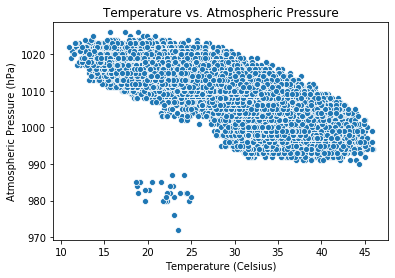

In [12]:
# Scatter plot of air presure across temperature
%matplotlib inline

#initializing the plot
sns.scatterplot(x = 'temp', y = 'pressure', data = weath_df).set_title('Temperature vs. Atmospheric Pressure')

#setting labels
plt.xlabel('Temperature (Celsius)')
plt.ylabel('Atmospheric Pressure (hPa)')

That low presure group requires further exploration.

In [13]:
# Creating a dataframe that only includes data where air pressure was below 990
low_pres = weath_df.loc[weath_df['pressure'] < 990]

Text(0, 0.5, 'Atmospheric Pressure (hPa)')

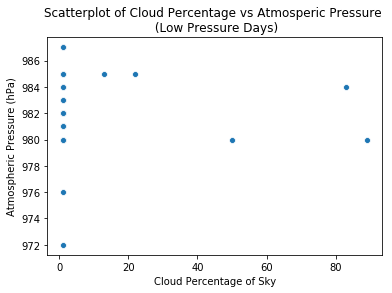

In [14]:
# Scatter plot of air pressure vs. cloud percentage for a given low air pressure day
#initializing the plot
sns.scatterplot(x = 'pct_cloudy', y = 'pressure', data = low_pres).set_title('Scatterplot of Cloud Percentage vs Atmosperic Pressure \n (Low Pressure Days)')

#setting labels
plt.xlabel('Cloud Percentage of Sky')
plt.ylabel('Atmospheric Pressure (hPa)')

Text(0, 0.5, 'Atmospheric Pressure (hPa)')

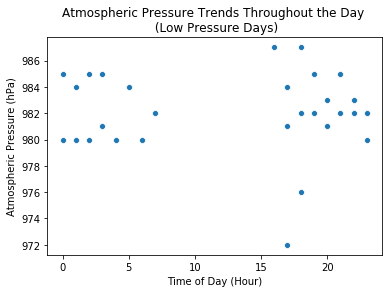

In [15]:
# Scatterplot of air pressure over time on days wher air pressure is low

sns.scatterplot(x = 'time', y = 'pressure', data = low_pres).set_title('Atmospheric Pressure Trends Throughout the Day \n (Low Pressure Days)')

plt.xlabel('Time of Day (Hour)')
plt.ylabel('Atmospheric Pressure (hPa)')

Text(0, 0.5, 'Temperature (Celsius)')

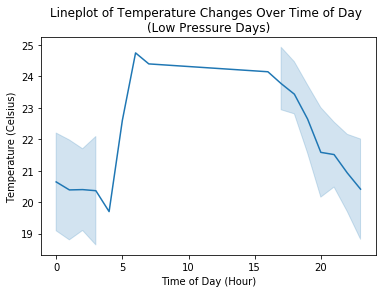

In [16]:
# Line plot of temperature change over time on days where air pressure was low

sns.lineplot(x = 'time', y = 'temp', data  = low_pres).set_title('Lineplot of Temperature Changes Over Time of Day \n(Low Pressure Days)')

plt.xlabel('Time of Day (Hour)')
plt.ylabel('Temperature (Celsius)')

It seems like this trend for low atmospheric pressure is exclusive to early mornings and evenings. This finding is consistent with previous research that has shown atmospheric pressure fluctuations to be caused by the settling of weather upon a given area.

During the evening, the Earth begins to cool and warms up once more as the sun begins to rise.

How does this compare to the data at large?

(18, 35)

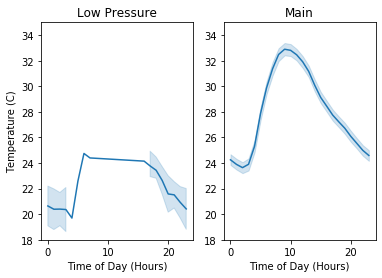

In [17]:
# Two subplots of temperature throughout the day for low pressure and all days
fig, ax = plt.subplots(1,2)

#Setting plot titles
ax[0].title.set_text('Low Pressure')
ax[1].title.set_text('Main')

#creating the plots
sns.lineplot(x = 'time', y = 'temp', data = weath_df, ax = ax[1])
sns.lineplot(x = 'time', y = 'temp', data  = low_pres, ax = ax[0])

#setting plot labels
ax[0].set_xlabel('Time of Day (Hours)')
ax[0].set_ylabel('Temperature (C)')
ax[1].set_xlabel('Time of Day (Hours)')
ax[1].set_ylabel('')

#setting y-axis limits
ax[1].set_ylim([18,35])
ax[0].set_ylim([18,35])

As these visualizations show, low atmospheric pressure days have been characterized by overall lower temperature trends. As Dubai is already a warmer part of the world, cold low pressure days are not common. Additionally, with the effects of global warming, such days are expected to become rarer as greenhouse gases fill the atmosphere and atmospheric pressures continue to rise.

# Modeling weather within Dubai:

In order to prepare for climate change related effects on Dubai, we must have a dependable model that can predict what the weather may be. This information will help to analyze daily trends, taking into account time of day, and meterological data. With these result, we can begin to paint the picture of the environment that the Dubai transit system finds itself in.

I have chosen to model this through a Random Forest Regressor as it is robust enough to handle many features and has the capability to determine importance. Additionally, it is self correcting thus resilient to overfitting.

In [18]:
#Head of the weather dataframe
weath_df.head()

,date,time,main,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,pct_cloudy,rv_1h,rv_3h
0,2018-01-01,0,NaN,14.99,13.0,18.0,13.70,1015.0,87.0,3.1,150.0,1,NaN,NaN
1,2018-01-01,1,NaN,14.63,13.0,17.0,13.91,1015.0,93.0,2.6,150.0,1,NaN,NaN
2,2018-01-01,2,NaN,14.03,12.0,17.0,13.89,1016.0,93.0,1.5,150.0,1,NaN,NaN
3,2018-01-01,3,NaN,13.78,12.0,17.0,13.14,1016.0,93.0,2.1,180.0,1,NaN,NaN
4,2018-01-01,4,NaN,14.28,12.0,18.0,13.45,1017.0,93.0,2.6,160.0,1,NaN,NaN


In [19]:
#Dividing data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(weath_df.drop(['temp', 'main', 'date', 'rv_1h','rv_3h'], axis = 'columns'), 
                                                    weath_df['temp'], test_size = 0.2)

In [20]:
#Initializing the Random Forest Regressor
rfr = RandomForestRegressor(n_estimators = 30, min_samples_split = 0.15, oob_score = True)

In [21]:
# Training the model
mod = rfr.fit(X_train, y_train)

In [22]:
#Storing the predicted values
y_pred = mod.predict(X_test)

In [23]:
#Model score
mod.score(X_test,y_test)

0.9572558558670313

In [24]:
#Model score using the out of bag data
mod.oob_score_

0.9564104047394487

Text(0, 0.5, 'Actual Temperature')

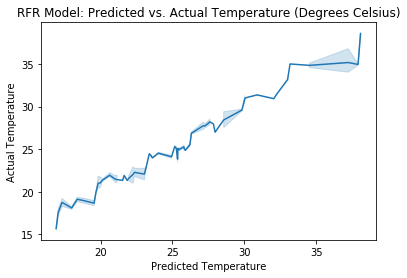

In [25]:
#Line Plot comparing predicted vs. test outcomes
sns.lineplot(x = y_pred, y = y_test).set_title('RFR Model: Predicted vs. Actual Temperature')
plt.xlabel('Predicted Temperature (C)')
plt.ylabel('Actual Temperature (C)')

In [26]:
#Feature importances of the model
mod.feature_importances_

array([0.        , 0.99094318, 0.00905682, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

### Analysis

As shown by the model, performance begins to vary as temperature changes begin to fluctuate. This varying in temperature may come from the models dependency to predict temperature based on time of day and minimum temperature. As shown previously, the variation in these variables stems from changing atmospheric pressure due to global warming. In fact, performance decreases as temperature rises, again as a product of the varied atmospheric pressure that Dubai is experiencing. Future models should work to accomodate varying and ever-evolving meteorological data 

## Bus Routes and Infrastructure

### Cleaning Bus Data

In [27]:
#Loading Bus_Routes.csv file and presenting the dataframe head
bus_rt = pd.read_csv("Bus_Routes.csv")
bus_rt.head()

,route_name,route_type,direction,stop_name,stop_number
0,10,Urban,GSBS1 -> QZBSB1,Gold Souq Bus Station 1,0
1,10,Urban,GSBS1 -> QZBSB1,Naif Intersection 1,1
2,10,Urban,GSBS1 -> QZBSB1,"Naif, Intersection 1",1
3,10,Urban,GSBS1 -> QZBSB1,"Burj Nahar, Intersection 1",2
4,10,Urban,GSBS1 -> QZBSB1,Al Nakhal 1 1,3


In [28]:
#Initializing empty lists to store departure and destination names
departure = []
destination = []

#Function to seperate the direction column into more manageable strings
def direction_split(string):
    
    #string -> a string object from the direction column
    
    #splitting the string on the arrow substring
    split = string.split('->')
    
    #stripping resulting string of whitespace
    for txt in split:
        
        txt.strip()
        
    #appending resulting string into its corresponding list
    #index 0 indicates departures
    #index 1 indicates destinations
    
    departure.append(split[0])
    destination.append(split[1])
    
    #returns resulting string into the direction column
    #in order to ensure proper modifications were done
    return string

In [29]:
#Checking unique values
#Our head showed two values that were the same, yet labeled differently
bus_rt['stop_name'].unique()

array(['Gold Souq Bus Station 1', 'Naif Intersection 1',
       'Naif, Intersection 1', ..., 'Al Ghubaiba Bus Station H',
       'Ghubaiba Bus Station H', 'Al Jafiliya Bus Station 5'],
      dtype=object)

In [30]:
#cleaning the stop_name column

#initializing an empty list to store standardized stop names
stop = []

def stop_standardizer(string):
    
    '''string -> a string object found within the stop column'''
    
    #changing names to lower case, removing punctuation and whitespace
    #will standarndize format to minimize uniqueness within the column
    string = string.lower()
    string = string.replace(',','')
    string = string.strip()
    
    #appending resulting string to the stop list
    stop.append(string)
    
    #returning string for comparison
    return string

In [31]:
#applying standardization functions
bus_rt['direction'].apply(direction_split)
bus_rt['stop_name'].apply(stop_standardizer)

#adding new columns from the new lists
bus_rt['stop_test'] = stop
bus_rt['departure'] = departure
bus_rt['destination'] = destination

#dropping uneeded columns
bus_rt = bus_rt[['route_name', 'route_type', 'departure', 'destination','stop_test','stop_number']]

In [32]:
#renaming columns
bus_rt = bus_rt.rename(columns = {'route_name':'rt_name', 'route_type':'rt_type', 
                                  'stop_test':'stop', 'stop_number': 'stop_num'})
#presenting the head
bus_rt.head()

,rt_name,rt_type,departure,destination,stop,stop_num
0,10,Urban,GSBS1,QZBSB1,gold souq bus station 1,0
1,10,Urban,GSBS1,QZBSB1,naif intersection 1,1
2,10,Urban,GSBS1,QZBSB1,naif intersection 1,1
3,10,Urban,GSBS1,QZBSB1,burj nahar intersection 1,2
4,10,Urban,GSBS1,QZBSB1,al nakhal 1 1,3


## Network Plot 
To show interconnectedness and complexity of bus routes through departure and destination locations.
(Model will present itself in a new window)

In [33]:
#clearing lists of whitespace
departure = [i.strip() for i in departure]
destination = [i.strip() for i in destination]

In [34]:
#Creating a dictionary with departure as a keys and destination as values
dic = {departure[i]: destination[i] for i in range(len(departure))}

In [35]:
#Creating the edges list, a list of tuples
edges = [(k, v) for k, v in dic.items()] 

In [36]:
#Creating the graph
G = nx.OrderedGraph()

#Adding nodes, departure list contains same entries as destination
#only using departure, so as to not create duplicates
G.add_nodes_from(departure)

#Adding edges (links between stations)
G.add_edges_from(edges)

In [37]:
# Converting the node degree from a Degree View object to a dictionary
deg_dic = dict(G.degree())

In [38]:
#Finding top 6 departure sites with the highest degree
sorted(deg_dic, key=deg_dic.get, reverse=True)[:6]

['SG31', 'EECT', 'MENBD1', 'RMSP1', 'URCC54', 'JAMSS1']

In [39]:
#displaying their degree values
G.degree(['SG31', 'EECT', 'MENBD1', 'RMSP1', 'URCC54', 'JAMSS1'])

DegreeView({'SG31': 17, 'EECT': 14, 'MENBD1': 12, 'RMSP1': 8, 'URCC54': 7, 'JAMSS1': 6})

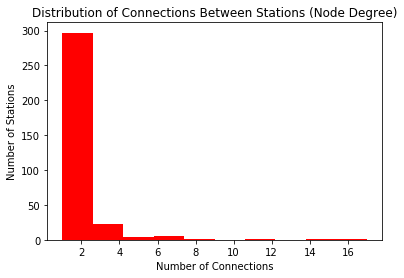

In [40]:
#Histogram of Degree Distribution
plt.title('Distribution of Connections Between Stations (Node Degree)')

plt.hist(list(deg_dic.values()),color='r')

plt.xlabel('Number of Connections')
plt.ylabel('Number of Stations')
plt.show()

As this graph shows, the top 6 stations that were just identified are special cases. All six fall well outside of what is typical for a dubai bus station, thus deserve further analysis. These stations are considered to be at most risk to the indirect effects of climate change.

In [41]:
#List of high degree departure sites
high_dg = ['SG31','EECT', 'MENBD1', 'RMSP1', 'URCC54', 'JAMSS1']

#Dictionary of high degree departure sites
high_dg_dic = dict(G.degree(['SG31', 'EECT', 'MENBD1', 'RMSP1', 'URCC54', 'JAMSS1']))

#Dictionary of departure sites to be used as node labels
labels = {'SG31':'SG31', 'EECT':'EECT', 'MENBD1':'MENBD1', 'RMSP1':'RMSP1', 'URCC54':'URCC54', 'JAMSS1':'JAMSS1'}

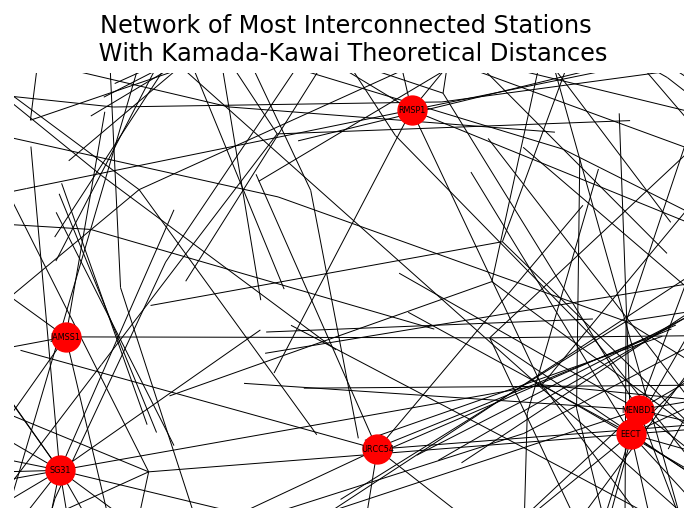

In [67]:
%matplotlib inline
%matplotlib qt

#Adding title
plt.title('Network of Most Interconnected Stations \n With Kamada-Kawai Theoretical Distances')

#Creating the planar network graph, only assigning nodes to stations of highest degree
nx.draw_kamada_kawai(G, labels = labels, nodelist = high_dg, 
               node_size = 200, width = 0.5, node_color = 'r',
               font_color = 'k', font_size = 4)


plt.draw()
plt.show()

In [43]:
#Creating a dataframe including only high degree departure sites
net_rt = bus_rt.loc[bus_rt['departure'].isin(['SG31 ','EECT ','MENBD1 ','RMSP1 ','URCC54 ','JAMSS1 '])]

#Printing
print('Number of Unique Bus Routes Connected to at-risk Stations:', net_rt['rt_name'].nunique())
print('\n')
print('Number of Unique Bus Stations Connected to at-risk Stations:', sum(high_dg_dic.values()))
print('\n')
print('Bus Routes Identifiers:', '\n', net_rt['rt_name'].unique())

Number of Unique Bus Routes Connected to at-risk Stations: 74


Number of Unique Bus Stations Connected to at-risk Stations: 64


Bus Routes Identifiers: 
 ['365' '366' '4' '44' '99' 'F03' 'F05' 'F06' 'F10' 'GD1' 'GD10' 'GD11'
 'GD12' 'GD12A' 'GD14' 'GD15' 'GD16' 'GD18' 'GD19' 'GD2' 'GD20' 'GD21'
 'GD22' 'GD22A' 'GD23' 'GD24' 'GD25' 'GD29' 'GD3' 'GD4' 'GD5' 'GD5A' 'GD6'
 'GD7' 'GD8' 'GD8A' 'GD8B' 'GD9' 'GE24' 'GE27' 'GE28' 'GE63' 'GE79' 'GE83'
 'GK1' 'GK1A' 'GK1B' 'GK2' 'GK2A' 'GK2B' 'GK3' 'GK4' 'GK5' 'GK6' 'MD01'
 'MD02' 'MD03' 'MD04' 'MD05' 'MD06' 'MD08' 'MD09' 'MD10' 'MD11' 'MD21'
 'MD22' 'MD23' 'MD24' 'MD3A' 'S16' 'S18' 'S20' 'S21' 'S22']


# Discussion

As this network plot shows, stations SG31, EECT, MENBD1, RMSP1, URCC54, and JAMSS1 connect many stations together. These departure stations are at highest risk for delay, as failure at any of these sites could lead to delays with the network at large. As shown in the previous column, these six departure sites connect to 74 different bus routes and 64 different stations. In particular, SG31 is the stop connected with 17 different stations. As the threat of climate change looms closer, stations such as SG31 are at most risk as their complexity & interconnectedness will increase its vulnerability. 

Highly interconnected stations are often a sign of old infrastructure that has yet to be updated to a more flexible and agile model (Chester & Allenby 2017). These sorts of stations are prone to climate change effects, and are typically only temporarily remedied by robust modifications that only account for the direct influences of weather (Markolf et. al, 2019). Other indirect effects such as congestion from interconnected systems, convoluted routes, and the general "wear & tear" effects these stations experience can lead to even further delays (Markolf et. al, 2019). However, most of the indirect pathways to failure are often neglected.

In order to begin updating these stations to be more flexible and agile in preperation for climate change, updates in the fields of route roadmapping and software updates are in order. Flexibility is broadly defined as the ability to reconfigure and alter system parameters in order to absorb and react to foreseeable changes and uncertainties, and agility is broadly defined as the ability to adapt and evolve in an environment of continuous and unanticipated changes (Bernardes & Hanna, 2009). Flexibility & agility are thus valuable metrics to consider when determining a stations adaptive resiliency to climate change.

An agile and flexible public transit system would have the following traits (Ashby, 1956, 1960; Lawrence and Lorsch, 1967; Hatch, 1997; Vecchio, 2006; Sherehiy et al., 2007):

- Responsiveness: the ability to sense, perceive, and anticipate changes/disruptions


- Modular, Connective, and Compatible Technical Structures: integration and cooperation within and across both internal and external entities, empowered people and processes within and across both internal and external entities, cultures of inquiry and experimentation


- Organic and Experimental Organizational Culture: informal and open communication, few levels of hierarchy, distributed decision making, fluid role definitions, empowered people and processes, and cultures of inquiry and experimentation


#### In order to ensure that Dubai's bus system can scale with the direct and indirect effects of global warming, future work should progress towards a flexible and agile system that both relieves complexity, and updates interconnected infrastructure from a robust, to a resilient model.

#### Notes: 
I debated whether or not to even include the RFR model in this analysis, but it served as a good learning experience as to how a model could potentially be implemented. In the future, I aim to continue to focus on analysis and interpretation before I begin to create predictive models.Additionally, it would have been good to include further evidence that these stations were at risk from many angles, which is likely the case. For the purpose of this practice project, I intended to gain experience in the Data Science process. In the future, I intend to have a much more direct and refined approach.Overall, I learned a lot from this experience and I look forward to working on all my weak points.
## Bibliography:

Ashby, 1956
W.R. Ashby
An Introduction to Cybernetics
John Wiley & Sons Inc, New York (1956)
Google Scholar

Ashby, 1960
W.R. Ashby
Design for a Brain: the Origin of Adaptive Behavior
Chapman & Hall (1960)
Google Scholar

Bernardes and Hanna, 2009
E.S. Bernardes, M.D. Hanna
A theoretical review of flexibility, agility and responsiveness in the operations management literature: toward a conceptual definition of customer responsiveness
Int. J. Oper. Prod. Manag., 29 (1) (2009), pp. 30-53, 10.1108/01443570910925352

Chester and Allenby, 2017
M.V. Chester, B. Allenby
Towards adaptive infrastructure: flexibility and agility in a non-stationarity age. Under review at sustainable and resilient infrastructure
Draft available at:
https://repository.asu.edu/items/44743 (2017)
Google Scholar

Hatch, 1997
M.J. Hatch
Organization Theory: Modern, Symbolic, and Postmodern Perspectives
Oxford University Press, Oxford (1997)
Google Scholar

Lawrence and Lorsch, 1967
P.R. Lawrence, J.W. Lorsch
Differentiation and integration in complex organizations
Adm. Sci. Q., 12 (1) (1967), pp. 1-47, 10.2307/2391211
CrossRefView Record in ScopusGoogle Scholar

Markolf, 2019
“Transportation Resilience to Climate Change and Extreme Weather Events – Beyond Risk and Robustness.” 
Transport Policy, Pergamon, 23 Nov. 2019, 
www.sciencedirect.com/science/article/pii/S0967070X17305000#bib23.

Sherehiy et al., 2007
B. Sherehiy, W. Karwowski, J.K. Layer
A review of enterprise agility: concepts, frameworks, and attributes
Int. J. Ind. Ergon., 37 (2007), pp. 445-460, 10.1016/j.ergon.2007.01.007

Vecchio, 2006
R.P. Vecchio
Organizational Behavior: Core Concepts
Thomson/Southern-Western (2006)
Google Scholar